In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
TABLES_DIRECTORY = "../../Data/giant_new_tables"

In [5]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [
    160,
    172,
    # 141, # not enough time before first seizure
    145,
    138,
    142,
    151,
    187,
    180,
    184,
    # 192, # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    # 165, # incomplete data
    # 169, # not enough time after the last seizure
    173,
    # 150, # not enough time before first seizure
    # 154, # incomplete data
    # 158, # incomplete data
    # 207, # not enough time before first seizure
    # 223,
    # 192,  ## Monday, August 21, 2023 additions this line and below # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    177,
    185,
    # 189, # not enough time before first seizure
    # 205, # not enough time before first seizure
    166,
    # 210,
    # 170, # not enough time before first seizure
    # 174, # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

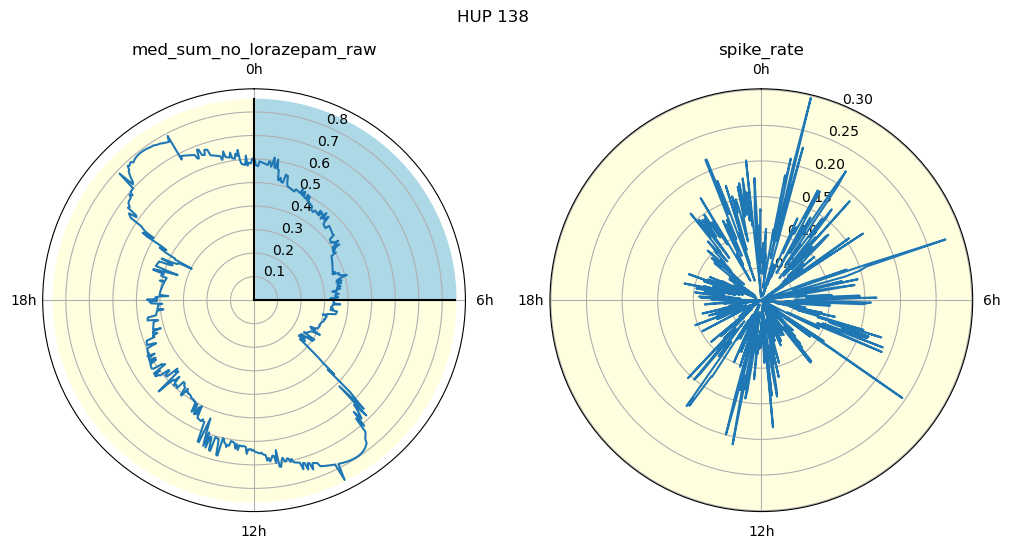

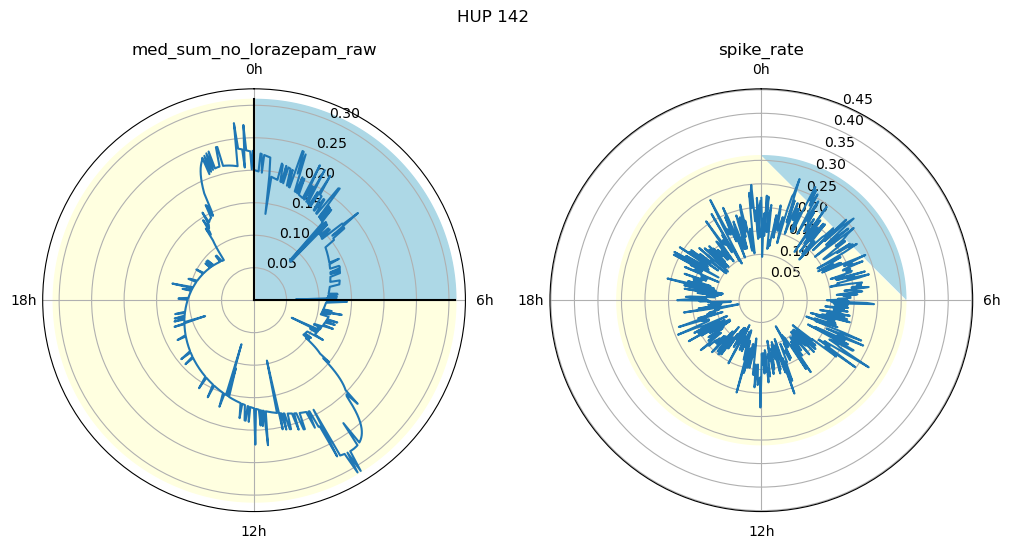

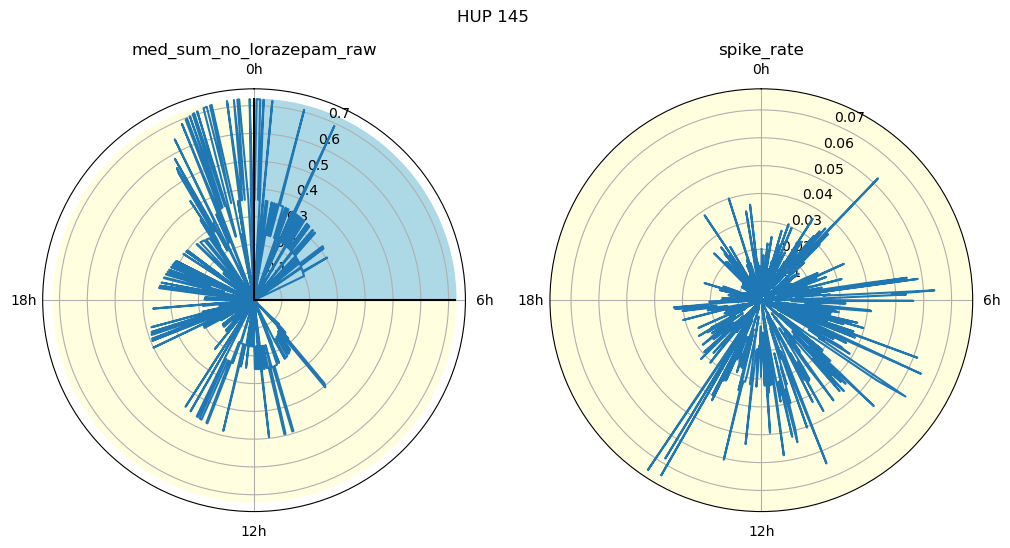

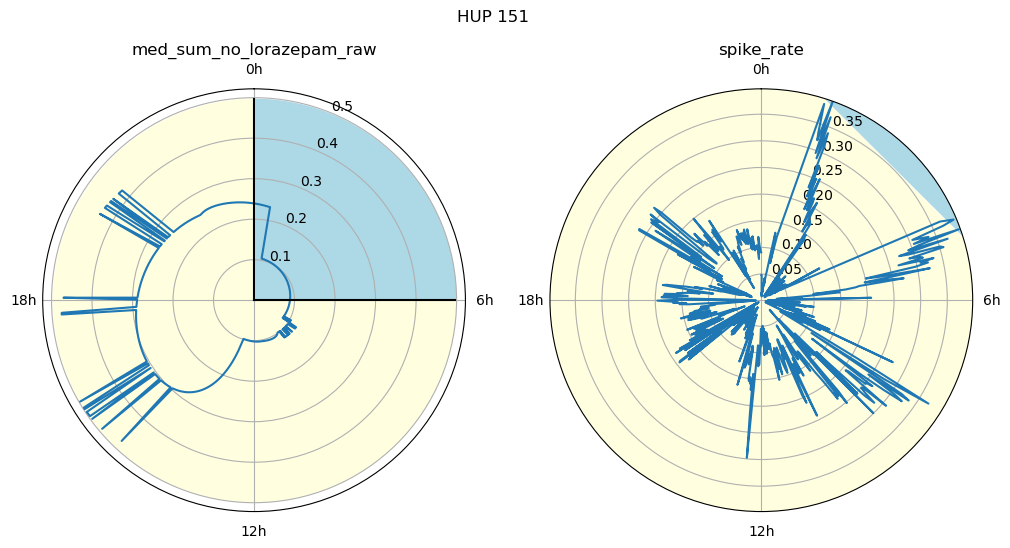

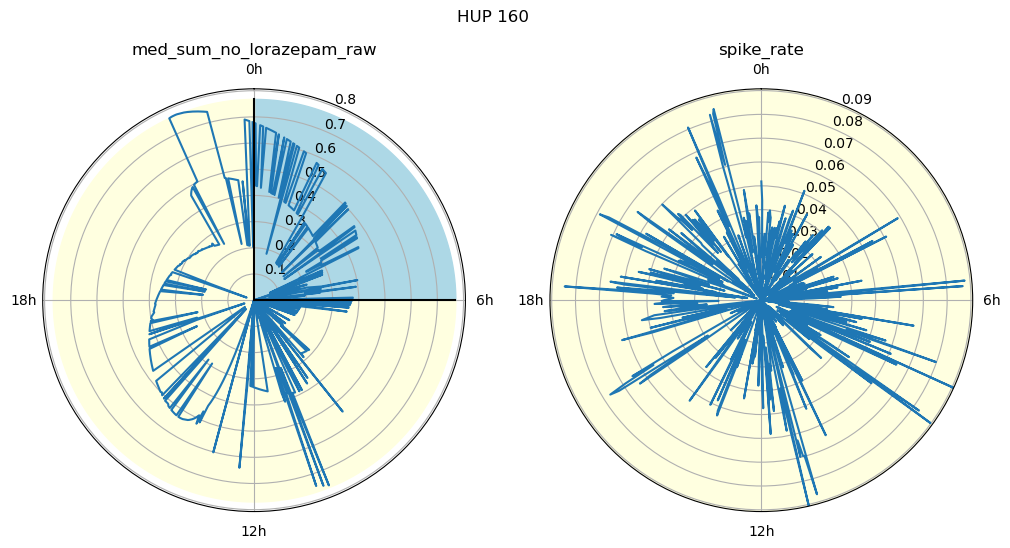

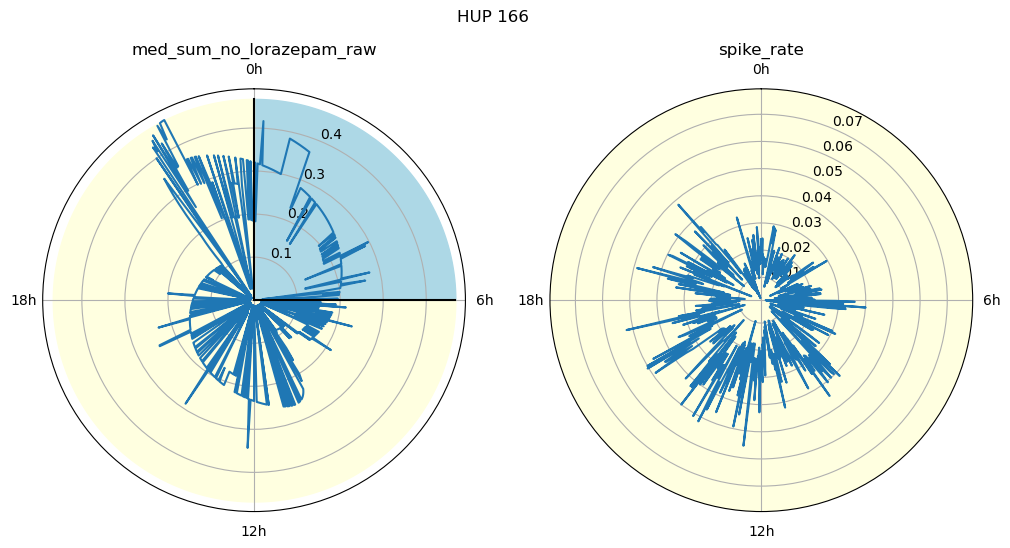

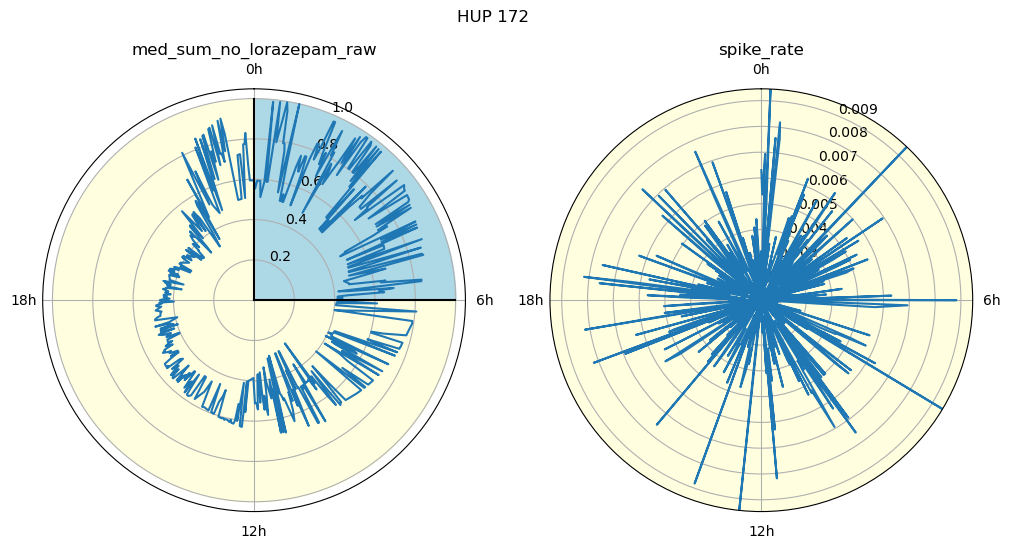

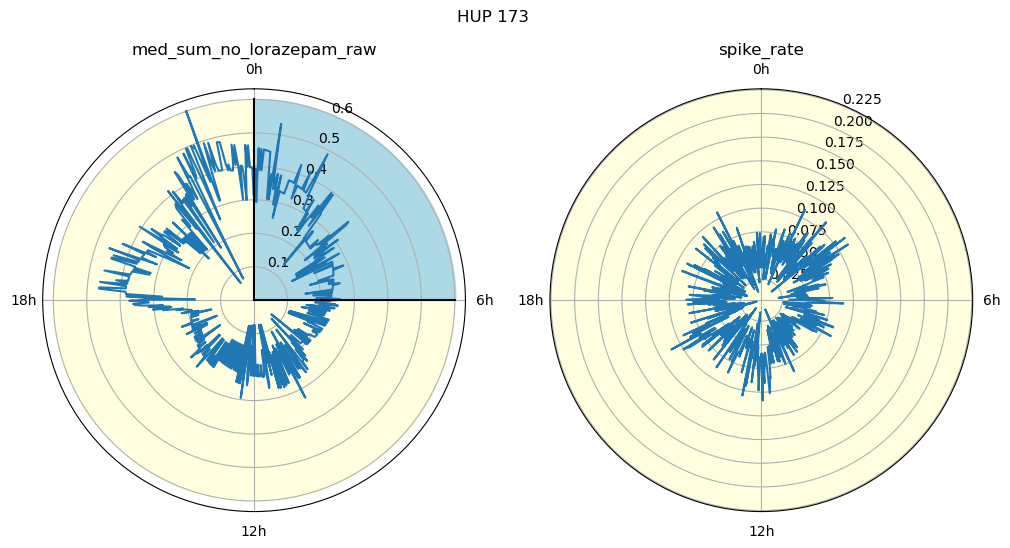

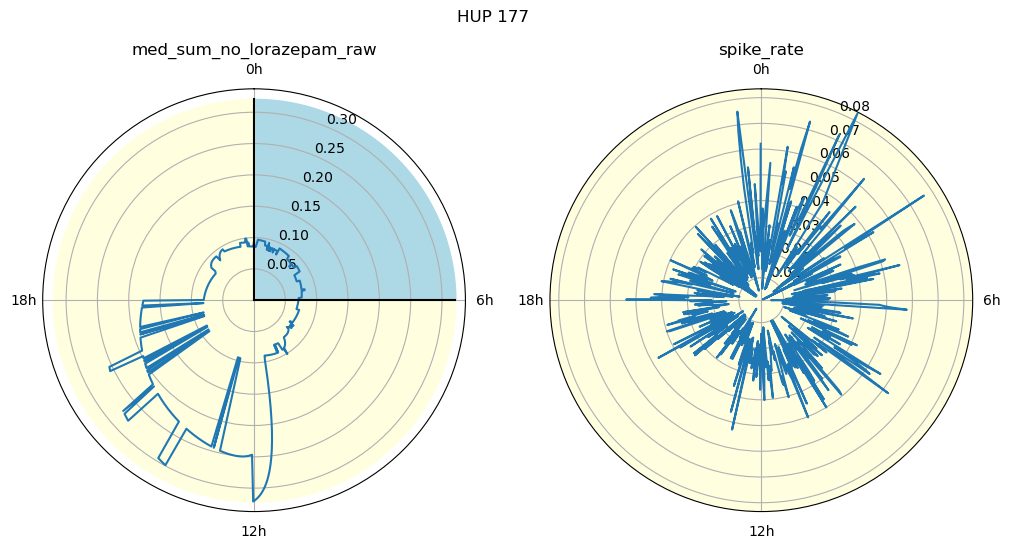

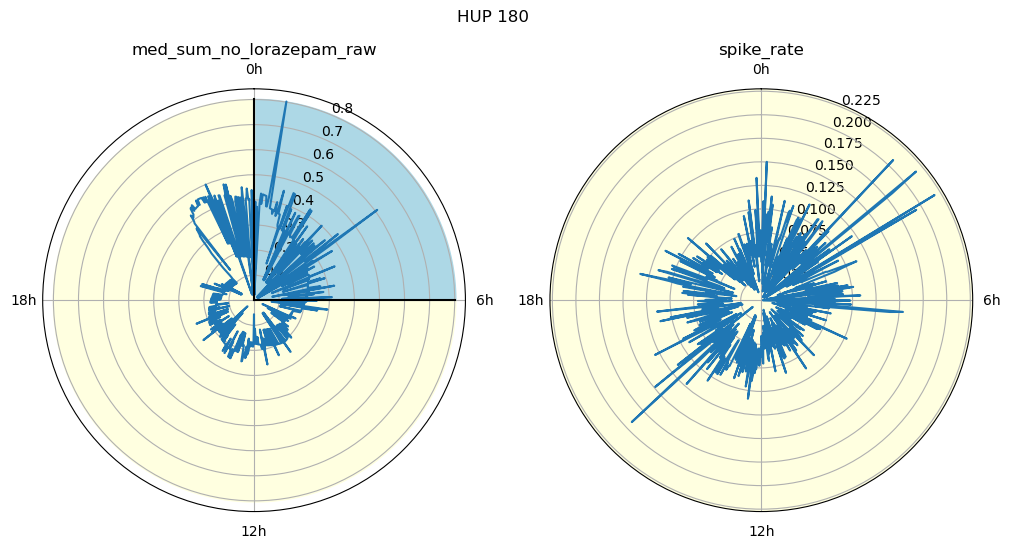

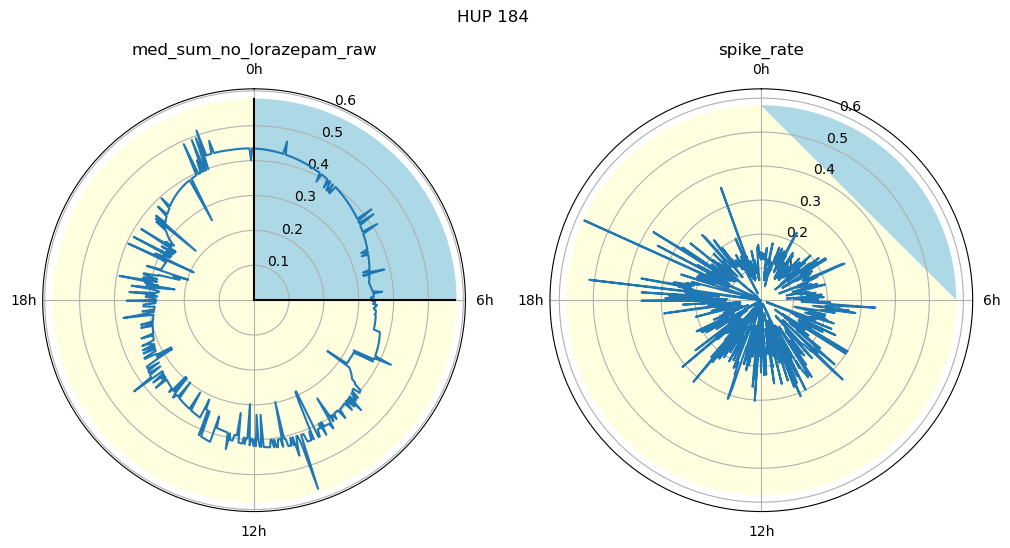

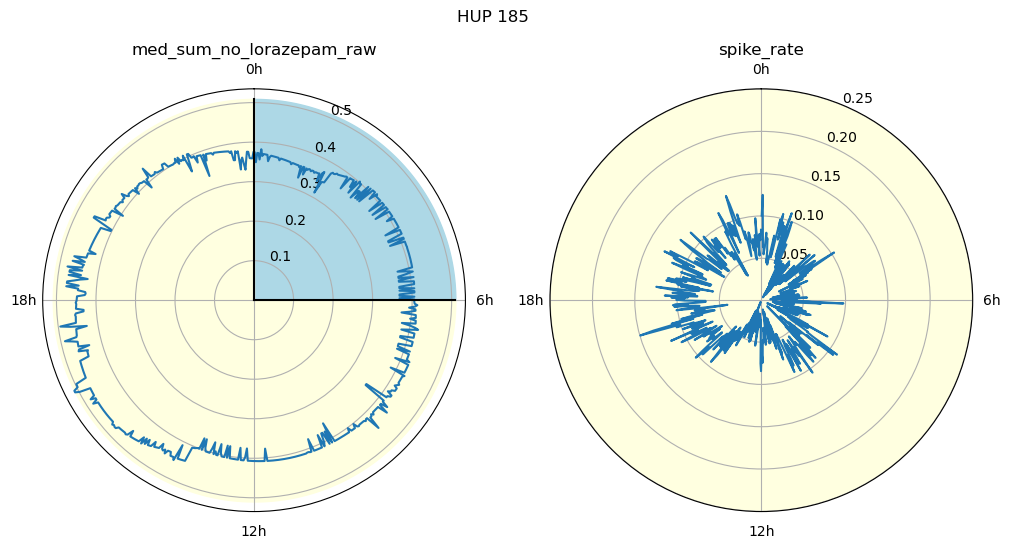

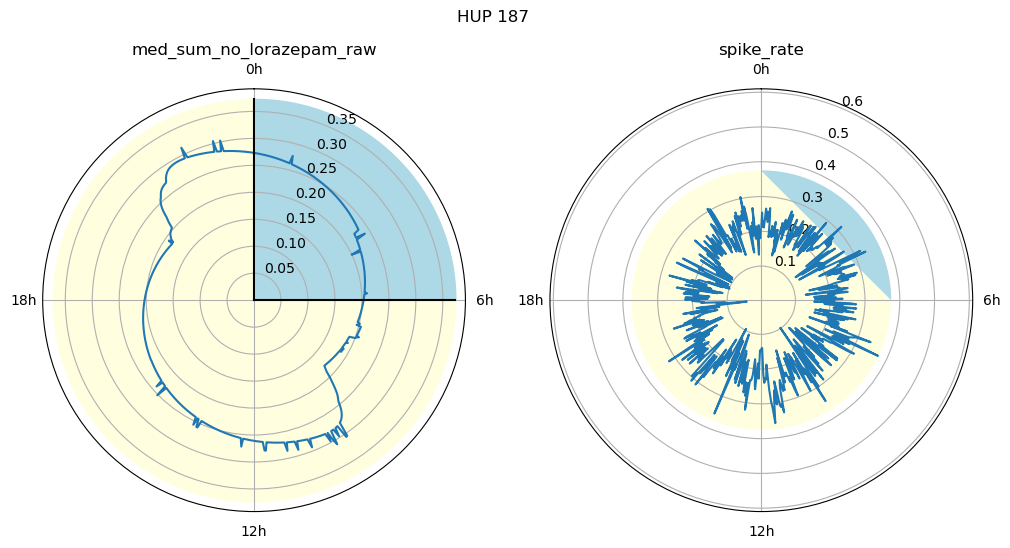

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def time_to_angle(time_str):
    # Convert time string to hours and minutes
    hours, minutes, _ = map(int, time_str.split(":"))
    total_minutes = hours * 60 + minutes

    # Convert total minutes to angle in radians
    # There are 1440 minutes in a day, so the conversion factor is 2 * pi / 1440
    angle = 2 * np.pi * total_minutes / 1440
    return angle


for patient_hup_id in completed_hup_ids:
    # Load the dataframe
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )

    # 1. Drop columns that are all zeros and rows with NaN values
    hourly_patient_features_df = hourly_patient_features_df.loc[
        :, (hourly_patient_features_df != 0).any(axis=0)
    ]
    hourly_patient_features_df = hourly_patient_features_df.dropna()

    # Determine outliers using IQR for the spike_rate column
    Q1 = hourly_patient_features_df["spike_rate"].quantile(0.25)
    Q3 = hourly_patient_features_df["spike_rate"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    hourly_patient_features_df = hourly_patient_features_df[
        (hourly_patient_features_df["spike_rate"] >= lower_bound)
        & (hourly_patient_features_df["spike_rate"] <= upper_bound)
    ]

    # Determine min and max of spike_rate after filtering outliers
    min_spike_rate = hourly_patient_features_df["spike_rate"].min()
    max_spike_rate = hourly_patient_features_df["spike_rate"].max()

    # 2. Convert 'actual_time' column to angles in radians
    hourly_patient_features_df["angle"] = hourly_patient_features_df[
        "actual_time"
    ].apply(time_to_angle)

    # 3. Average the med_sum_no_lorazepam_raw and spike_rate for the same time of day
    avg_med_sum = hourly_patient_features_df.groupby("angle")[
        "med_sum_no_lorazepam_raw"
    ].mean()
    avg_spike_rate = hourly_patient_features_df.groupby("angle")["spike_rate"].mean()

    # 4. Plotting
    fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=(12, 6))

    ax[0].plot(avg_med_sum.index, avg_med_sum.values)
    ax[0].set_title("med_sum_no_lorazepam_raw")
    # ax[0].set_ylim(0, 1)  # Limit the y-axis
    ax[1].plot(avg_spike_rate.index, avg_spike_rate.values)
    ax[1].set_title("spike_rate")
    ax[1].set_ylim(
        min_spike_rate, max_spike_rate
    )  # Limit the y-axis for spike_rate using the min and max values

    # Adjustments for polar plot layout
    for a in ax:
        a.set_theta_zero_location("N")
        a.set_theta_direction(-1)  # Clockwise
        a.set_xticks(
            np.pi / 2 * np.array([0, 1, 2, 3])
        )  # 0, 90, 180, 270 degree positions
        a.set_xticklabels(["0h", "6h", "12h", "18h"])

        # Drawing lines at 0 hour and 6 hours
        a.plot([0, 0], [0, max(max(avg_med_sum), max(avg_spike_rate))], color="black")
        a.plot(
            [np.pi / 2, np.pi / 2],
            [0, max(max(avg_med_sum), max(avg_spike_rate))],
            color="black",
        )

        # Filling the section between 0 and 6 hours with light blue, rest with light yellow
        theta = np.linspace(0, 2 * np.pi, 1000)
        r = np.full_like(theta, max(max(avg_med_sum), max(avg_spike_rate)))
        a.fill_between(
            theta, r, where=[t < np.pi / 2 for t in theta], color="lightblue"
        )
        a.fill_between(
            theta, r, where=[t >= np.pi / 2 for t in theta], color="lightyellow"
        )

    # Show the plot
    # Add patient_hup_id to the title
    fig.suptitle(f"HUP {patient_hup_id}")
    plt.show()